# MONGY: Training `PatchTSMixer` on Financial Candlestick Data
## Direct forecasting example

This notebooke demonstrates the usage of a `PatchTSMixer` model for a multivariate time series forecasting task. This notebook has a dependecy on HuggingFace [transformers](https://github.com/huggingface/transformers) repo. For details related to model architecture, refer to the [TSMixer paper](https://arxiv.org/abs/2306.09364).

In [1]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset, BaseDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

In [2]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
# We want to setup our context, horizon, and patch size based on our task. We want to use
# 4 hours of lookback to start, in order to predict the next 5 minutes of candles. Regarding
# patch length, we know that we will want a larger patch size, so we will start with 64 as
# a base case assumption
context_length = 60 * 4  # This will give us 4 hours of lookback (6 candles per min * 60 min per hour)
forecast_horizon = 3 # This will give us 3 minutes of predictions

In [4]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data"

TEST_DATASET = f"{DATA_DIR}/1min-candles-test-w-CANDLES.csv"

timestamp_col = 't'

test_data = pd.read_csv(
    TEST_DATASET,
    parse_dates=[timestamp_col]
)


In [5]:
test_data.head()

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,targ_red,targ_green,obs_vwap,cont_market_open,cont_market_extended
0,AAPL,2023-01-23,2023-01-23 05:30:00-05:00,137.32,137.32,137.32,137.32,270.0,0,0,137.3304,0,1
1,AAPL,2023-01-23,2023-01-23 05:31:00-05:00,137.32,137.35,137.25,137.25,2893.0,1,0,137.3064,0,1
2,AAPL,2023-01-23,2023-01-23 05:32:00-05:00,137.25,137.25,137.22,137.22,1208.0,1,0,137.2449,0,1
3,AAPL,2023-01-23,2023-01-23 05:33:00-05:00,137.22,137.25,137.22,137.25,3444.0,0,1,137.2497,0,1
4,AAPL,2023-01-23,2023-01-23 05:34:00-05:00,137.25,137.25,137.25,137.25,0.0,0,0,0.0000,0,1


In [6]:
# Check for NaN values
assert sum(test_data.isna().sum().to_list()) == 0

In [7]:


id_columns = ['ticker', 'date_string']
forecast_columns = ['targ_o', 'targ_c', 'targ_h', 'targ_l', 'targ_v', 'targ_red', 'targ_green']
observable_columns = ['obs_vwap']
control_columns = ['cont_market_open', 'cont_market_extended']

scaled_test_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    observable_columns=observable_columns,
    control_columns=control_columns,
    scaling=True,
)
scaled_test_tsp.train(test_data)
print("Done Scaled Test")

unscaled_test_tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_col,
    id_columns=id_columns,
    target_columns=forecast_columns,
    observable_columns=observable_columns,
    control_columns=control_columns,
    scaling=False,
)
unscaled_test_tsp.train(test_data)
print("Done Unscaled Test")


Done Scaled Test
Done Unscaled Test


In [8]:
scaled_test_dataset = ForecastDFDataset(
    scaled_test_tsp.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    observable_columns=observable_columns,
    prediction_length=forecast_horizon,
)

unscaled_test_dataset = ForecastDFDataset(
    unscaled_test_tsp.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column=timestamp_col,
    target_columns=forecast_columns,
    control_columns=control_columns,
    context_length=context_length,
    observable_columns=observable_columns,
    prediction_length=forecast_horizon,
)

## Training `PatchTSMixer` From Scratch

Adjust the following model parameters according to need.
- `d_model` (`int`, *optional*, defaults to 8):
    Hidden dimension of the model. Recommended to set it as a multiple of patch_length (i.e. 2-8X of
    patch_len). Larger value indicates more complex model.
- `expansion_factor` (`int`, *optional*, defaults to 2):
    Expansion factor to use inside MLP. Recommended range is 2-5. Larger value indicates more complex model.
- `num_layers` (`int`, *optional*, defaults to 3):
    Number of layers to use. Recommended range is 3-15. Larger value indicates more complex model.
- `mode`: (`str`, either to 'common_channel' or `mix_channel`)

In [9]:
# Indices for accessing the OHLC values in the tensors
I_OPEN = 0
I_CLOSE = 1
I_HIGH = 2
I_LOW = 3
I_VOLUME = 4
I_RED = 5
I_GREEN = 6

from typing import Optional


class MongyModel(PatchTSMixerForPrediction):

    def forward(
        self,
        past_values: torch.Tensor,
        future_values: Optional[torch.Tensor] = None,
        observed_mask: Optional[torch.Tensor] = None,
        output_hidden_states: Optional[bool] = False,
        return_loss: bool = True,
        return_dict: Optional[bool] = True,
    ):
        # Call the parent class's forward method to get the model's outputs
        outputs = super().forward(
            past_values,
            observed_mask=observed_mask,
            future_values=future_values,
            output_hidden_states=output_hidden_states,
            return_loss=False,  # Set return_loss to False to prevent the built-in loss computation
            return_dict=return_dict,
        )

        # # Snap the candles to the correct opening positions, before computing the loss
        # # This is the "training wheels" for the head. By helping the model with the portion
        # # of it's task that we can help with, we severly limit the task that is posed to the
        # # model
        _outputs = outputs.prediction_outputs
        
        last_context_close = past_values[..., -1, I_CLOSE]
        first_candle_open = _outputs[..., 0, I_OPEN]
        first_candle_delta = last_context_close - first_candle_open
        first_candle_delta = first_candle_delta.unsqueeze(-1).unsqueeze(-1)
        _outputs[..., 0:4] = _outputs[..., 0:4] + first_candle_delta


        first_candle_close = _outputs[..., 0, I_CLOSE]
        second_candle_open = _outputs[..., 1, I_OPEN]
        second_candle_delta = first_candle_close - second_candle_open
        _outputs[..., -2:, 0:4] = _outputs[..., -2:, 0:4] + second_candle_delta

        second_candle_close = _outputs[..., 1, I_CLOSE]
        third_candle_open = _outputs[..., 2, I_OPEN]
        third_candle_delta = second_candle_close - third_candle_open
        _outputs[..., -1, 0:4] = _outputs[..., -1, 0:4] + third_candle_delta


        
        # Apply your custom loss function
        loss_val = None
        if future_values is not None and return_loss:
            loss_val = custom_loss( # This loss func is defined below, the model will not work until it's defined
                past_values[..., self.prediction_channel_indices],    
                outputs.prediction_outputs[..., self.prediction_channel_indices],
                future_values[..., self.prediction_channel_indices]
            )
            outputs.loss = loss_val

        if not return_dict:
            output = (outputs.prediction_outputs,) + outputs[2:]
            return ((loss_val,) + output) if loss_val is not None else output

        return outputs

In [55]:
run_num = "snap_candle_4"
# run_num = "4_1min"
model_dir = f"./checkpoints/run_{run_num}/output/checkpoint-5000"
model = MongyModel.from_pretrained(model_dir)
model.eval()

MongyModel(
  (model): PatchTSMixerModel(
    (encoder): PatchTSMixerEncoder(
      (patcher): Linear(in_features=16, out_features=64, bias=True)
      (mlp_mixer_encoder): PatchTSMixerBlock(
        (mixers): ModuleList(
          (0-2): 3 x PatchTSMixerLayer(
            (patch_mixer): PatchMixerBlock(
              (norm): PatchTSMixerNormLayer(
                (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
              )
              (mlp): PatchTSMixerMLP(
                (fc1): Linear(in_features=225, out_features=450, bias=True)
                (dropout1): Dropout(p=0.5, inplace=False)
                (fc2): Linear(in_features=450, out_features=225, bias=True)
                (dropout2): Dropout(p=0.5, inplace=False)
              )
              (gating_block): PatchTSMixerGatedAttention(
                (attn_layer): Linear(in_features=225, out_features=225, bias=True)
                (attn_softmax): Softmax(dim=-1)
              )
            )
            (fe

In [56]:
from torchsummary import summary

# # Provide the input size of your model
# summary(model, (240, 512))

## Model Test Bench

In [57]:
import time
from typing import Tuple

def run_inference(context: torch.Tensor, futures: torch.Tensor, log_time: bool = False) -> torch.Tensor:
    model.eval()
    
    with torch.no_grad():
        start = time.perf_counter()
        _forecasts = model(context.unsqueeze(0), future_values=futures.unsqueeze(0), return_loss=False).prediction_outputs
        end = time.perf_counter()

        if log_time:
            print(f"Ran Inference in {end - start} seconds")
        return _forecasts.squeeze(0)

In [58]:
def post_process(_context: torch.Tensor, _futures: torch.Tensor, _forecasts: torch.Tensor, ticker: str, date_str: str) -> Tuple[torch.tensor]:
    _context_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _context[:,0].numpy(),
        'targ_c': _context[:,1].numpy(),
        'targ_h': _context[:,2].numpy(),
        'targ_l': _context[:,3].numpy(),
        'targ_v': _context[:,4].numpy(),
        'targ_red': _context[:,5].numpy(),
        'targ_green': _context[:,6].numpy(),
    })
    _futures_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _futures[:,0].numpy(),
        'targ_c': _futures[:,1].numpy(),
        'targ_h': _futures[:,2].numpy(),
        'targ_l': _futures[:,3].numpy(),
        'targ_v': _futures[:,4].numpy(),
        'targ_red': _futures[:,5].numpy(),
        'targ_green': _futures[:,6].numpy(),
    })
    _forecasts_df = pd.DataFrame({
        'ticker': ticker,
        'date_string': date_str,
        'targ_o': _forecasts[:,0].numpy(),
        'targ_c': _forecasts[:,1].numpy(),
        'targ_h': _forecasts[:,2].numpy(),
        'targ_l': _forecasts[:,3].numpy(),
        'targ_v': _forecasts[:,4].numpy(),
        'targ_red': _forecasts[:,5].numpy(),
        'targ_green': _forecasts[:,6].numpy(),
    })

    inverse_scaled_context = scaled_test_tsp.inverse_scale_targets(_context_df)
    inverse_scaled_futures = scaled_test_tsp.inverse_scale_targets(_futures_df)
    inverse_scaled_forecasts = scaled_test_tsp.inverse_scale_targets(_forecasts_df)
    
    # Convert context data to OHLC candle data
    context_ohlc = pd.DataFrame({
        'Open': inverse_scaled_context['targ_o'],
        'Close': inverse_scaled_context['targ_c'],
        'High': inverse_scaled_context['targ_h'],
        'Low': inverse_scaled_context['targ_l'],
    })
    
    # Convert futures to OHLC candle data
    futures_ohlc = pd.DataFrame({
        'Open': inverse_scaled_futures['targ_o'],
        'Close': inverse_scaled_futures['targ_c'],
        'High': inverse_scaled_futures['targ_h'],
        'Low': inverse_scaled_futures['targ_l'],
    })

    # Convert the forecasts to OHLC data
    forecasts_ohlc = pd.DataFrame({
        'Open': inverse_scaled_forecasts['targ_o'],
        'Close': inverse_scaled_forecasts['targ_c'],
        'High': inverse_scaled_forecasts['targ_h'],
        'Low': inverse_scaled_forecasts['targ_l'],
    })
    
    
    reals_ohlc = pd.concat([context_ohlc, futures_ohlc])
    return reals_ohlc, forecasts_ohlc

In [59]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd

def plot_candles(reals: pd.DataFrame, forecasts: pd.DataFrame, context_start_ts: pd.Timestamp) -> None:
    
    # Create custom styles for context, future, and forecast candles
    reals_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'figure.facecolor': 'w', 'axes.facecolor': 'w'})
    forecast_style = {
        'marketcolors': {
            'candle': {'up': 'white', 'down': 'black'},
            'edge': {'up': 'black', 'down': 'black'},
            'wick': {'up': 'black', 'down': 'black'},
            'ohlc': {'up': 'white', 'down': 'black'},
            'volume': {'up': 'white', 'down': 'black'},
            'vcedge': {'up': 'white', 'down': 'black'},
            'vcdopcod': False,
            'alpha': 0.9
        }, 
                'mavcolors': None,
        'y_on_right': True,
    }
    
    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 4))
    
    # Create a time series with a duration of 4 hours and 20 minutes at a 1-minute frequency
    end_time = context_start_ts + pd.Timedelta(hours=4, minutes=2)  # Should get us the 4 hrs, 3min of time stamps
    reals_index = pd.date_range(start=context_start_ts, end=end_time, freq='1min')
    
    # Set the created time series as the index of reals_ohlc
    reals.index = reals_index
    
    # Get the last 3 minutes of the reals index
    last_3_minutes = reals.index[-3:]
    
    # Create a new DataFrame to store the padded forecast candles
    padded_forecasts = pd.DataFrame(0.0, index=reals_index, columns=forecasts.columns)
    padded_forecasts.iloc[-3:] = forecasts

    # Trim each df, to only contain 1 hour of data
    reals = reals.iloc[-60:]
    padded_forecasts = padded_forecasts.iloc[-60:]
    
    # Plot the real candles on the first axis
    mpf.plot(reals, type='candle', ax=ax1, style=reals_style)
    
    # Plot the padded forecast candles on top of the real candles
    mpf.plot(padded_forecasts, type='candle', ax=ax1, style=forecast_style)
    
    # Set the same y-limits for both axes
    y_min = min(reals['Low'].min(), forecasts['Low'].min())
    y_max = max(reals['High'].max(), forecasts['High'].max())
    ax1.set_ylim(y_min, y_max)
    
    # Set plot title and labels
    ax1.set_title('Aggregated 1-Minute Candles')
    ax1.set_xlabel('Candle Index')
    ax1.set_ylabel('Price')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [60]:
from typing import Tuple

def theta_body(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Create the series of closes
    real_candle_closes = torch.cat(x[..., I_CLOSE], y_obs[..., I_CLOSE], dim=-1)
    forecasted_candle_closes = torch.cat(x[..., I_CLOSE], y_pred[..., I_CLOSE], dim=-1)

    # Get the series of opens
    real_candle_opens = y_obs[..., I_OPEN]
    forecasted_candle_opens = y_pred[..., I_OPEN]

def theta_single_pnl(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Get the close of the last real candle
    last_candle_close = x[..., -1, I_CLOSE]
    real_last_candle_close = y_obs[..., -1, I_CLOSE]
    real_forecasted_candle_close = y_pred[..., -1, I_CLOSE]

    # Compute if the position should be long or short, based on the real values
    is_long = real_last_candle_close > last_candle_close

    # Compute P/L of long position
    if is_long:
        pnl_real = real_last_candle_close - last_candle_close
        pnl_forecasted = real_forecasted_candle_close - last_candle_close
    
    # Compute P/L of short position
    else:
        pnl_real = last_candle_close - real_last_candle_close
        pnl_forecasted = last_candle_close - real_forecasted_candle_close

    error = pnl_real - pnl_forecasted

    sq_error = torch.square(error)
    abs_error = torch.abs(error)
    return sq_error, abs_error


def theta_pnl(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Create the series of closes
    real_candle_closes = torch.cat((x[..., I_CLOSE], y_obs[..., I_CLOSE]), dim=-1)
    forecasted_candle_closes = torch.cat((x[..., I_CLOSE], y_pred[..., I_CLOSE]), dim=-1)
    
    # Compute pnls
    real_pnl_long = real_candle_closes[..., -3:] - real_candle_closes[..., 0:3]
    forecasted_pnl_long = forecasted_candle_closes[..., -3:] - forecasted_candle_closes[..., 0:3]
    real_pnl_short = real_candle_closes[..., 0:3] - real_candle_closes[..., -3:]
    forecasted_pnl_short = forecasted_candle_closes[..., 0:3] - forecasted_candle_closes[..., -3:]

    # For each candle, compute long/short position
    is_long = real_pnl_long > 0

    real_pnl = torch.where(is_long, real_pnl_long, real_pnl_short)
    forecasted_pnl = torch.where(is_long, forecasted_pnl_long, forecasted_pnl_short)

    pnl_ae = torch.abs(real_pnl - forecasted_pnl)
    pnl_se = torch.square(real_pnl - forecasted_pnl)

    return pnl_se, pnl_ae

def pnl_factor(y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    pred_reds = y_pred[..., I_RED]
    pred_greens = y_pred[..., I_GREEN]
    pred_is_green = pred_greens > pred_reds

    real_reds = y_obs[..., I_RED]
    real_greens = y_obs[..., I_GREEN]
    real_is_green = real_greens > real_reds

    factor = torch.sum(pred_is_green != real_is_green) / 3
    # print(f"Predicted Is Green: {pred_is_green}")
    # print(f"Real Is Green: {real_is_green}")
    # print(f"Factor: {factor}")

    return factor

def custom_loss(x: torch.Tensor, y_pred: torch.Tensor, y_obs: torch.Tensor) -> torch.Tensor:
    # Compute PNL rediual for each candle
    pnl_se, pnl_ae = theta_single_pnl(x, y_pred, y_obs)
    print(pnl_se, pnl_ae)

    # Compute MSE and MAE of the OHLCV data
    mse = torch.nn.functional.mse_loss(y_pred, y_obs)
    mae = torch.nn.functional.l1_loss(y_pred, y_obs)

    
    custom_mse = torch.mean(mse + pnl_se) 
    custom_mae = torch.mean(mae + pnl_ae) 

    return (custom_mse + custom_mae) / 2

In [61]:
def infer_and_plot(example: dict, plot: bool = True) -> None:
    # Get the metadata for the example
    ticker, date_str = example['id']
    ts = pd.Timestamp(example['timestamp']).tz_localize("UTC").tz_convert("America/New_York")
    context_start = ts - pd.Timedelta(hours=3, minutes=59)

    print(f"{ticker} {date_str}: {ts.strftime('%I:%M %p')}")
    print("================================")
    # Get an example for inference
    _context = example['past_values']
    _futures = example['future_values']

    _forecasts = run_inference(_context, _futures)
    
    mse = torch.nn.functional.mse_loss(_forecasts[:, :7], _futures[:, :7])
    mae = torch.nn.functional.l1_loss(_forecasts[:, :7], _futures[:, :7])
    base_loss = (mse + mae) / 2

    pnl_se, pnl_ae = theta_pnl(_context, _forecasts[:, :7], _futures[:, :7])
    pnl_loss = torch.mean((pnl_se + pnl_ae))

    loss = custom_loss(_context, _forecasts[:, :7], _futures[:, :7])

    pnl_factor(_forecasts, _futures)
    
    
    # Print the evaluation metrics
    print("Base Loss Component:", base_loss.item())
    print("P/L Loss Component:", pnl_loss.item())
    print("Custom Loss:", loss.item())


    # Get the unscaled predictions, so that we can chart the data
    # _unscaled_context = unscaled_example['past_values']
    # _unscaled_futures = unscaled_example['future_values']

    # _unscaled_forecasts = run_inference(_unscaled_context, _unscaled_futures)
    
    reals_ohlc, forecasts_ohlc = post_process(_context, _futures, _forecasts, ticker, date_str)
    if plot: plot_candles(reals_ohlc, forecasts_ohlc, context_start)
    return _forecasts

AAPL 2023-01-23: 09:30 AM
tensor(0.2779) tensor(0.5271)
Base Loss Component: 1.1778035163879395
P/L Loss Component: 0.4449107348918915
Custom Loss: 1.5802860260009766


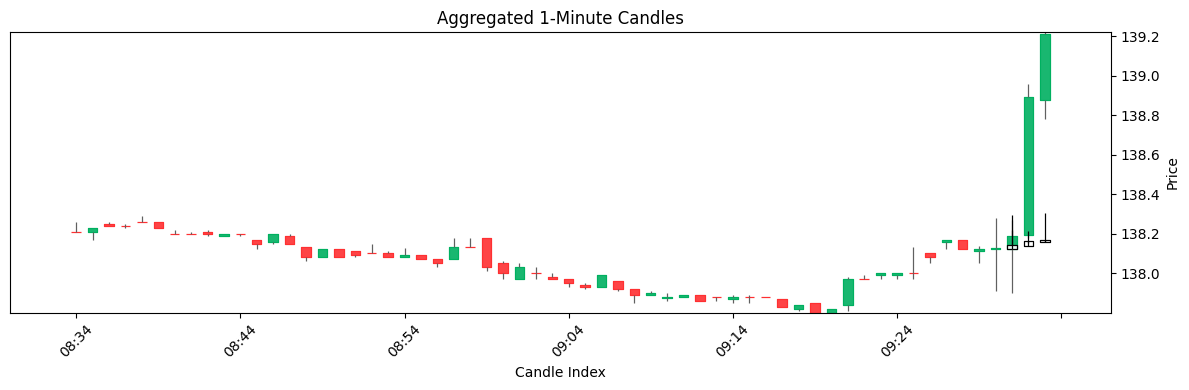

AAPL 2023-05-24: 11:45 AM
tensor(0.2653) tensor(0.5151)
Base Loss Component: 0.46098631620407104
P/L Loss Component: 0.6327243447303772
Custom Loss: 0.8511579036712646


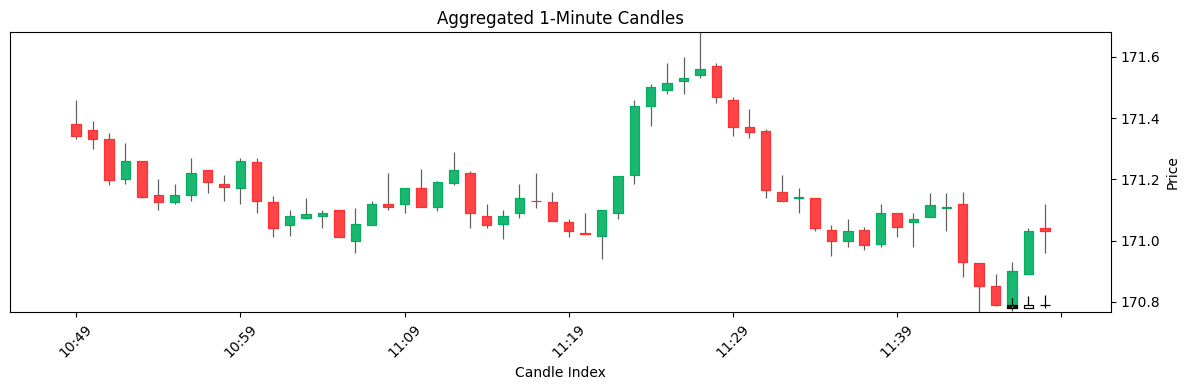

AAPL 2023-11-02: 02:00 PM
tensor(0.0248) tensor(0.1574)
Base Loss Component: 0.273104190826416
P/L Loss Component: 0.13923436403274536
Custom Loss: 0.3641892671585083


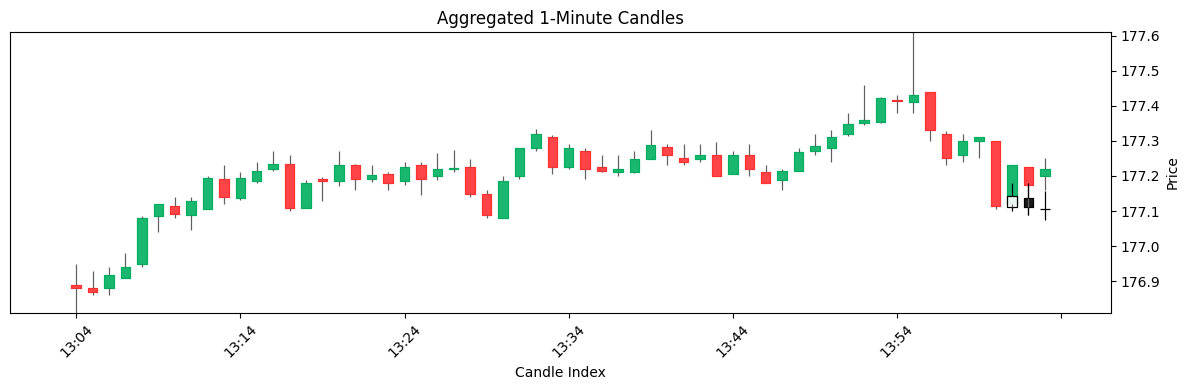

AMZN 2023-03-20: 09:47 AM
tensor(0.0438) tensor(0.2093)
Base Loss Component: 0.6214881539344788
P/L Loss Component: 0.20599877834320068
Custom Loss: 0.7480252981185913


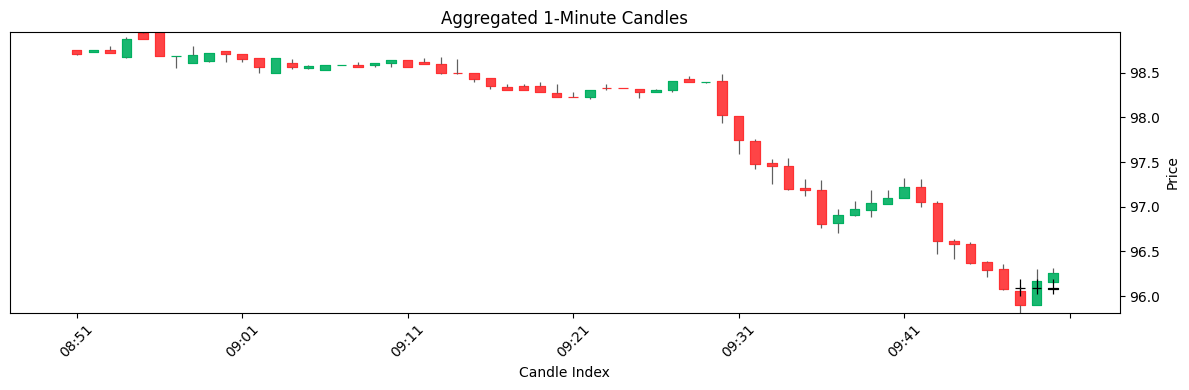

AMZN 2023-08-18: 12:02 PM
tensor(0.0042) tensor(0.0649)
Base Loss Component: 0.3579901456832886
P/L Loss Component: 0.12543749809265137
Custom Loss: 0.39254510402679443


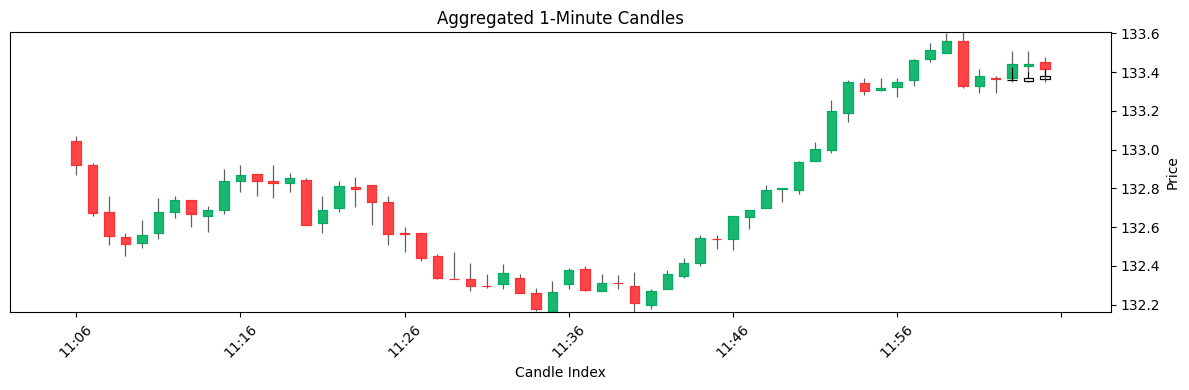

AMZN 2023-12-15: 02:17 PM
tensor(0.0067) tensor(0.0820)
Base Loss Component: 0.31554073095321655
P/L Loss Component: 0.08767157047986984
Custom Loss: 0.3598827123641968


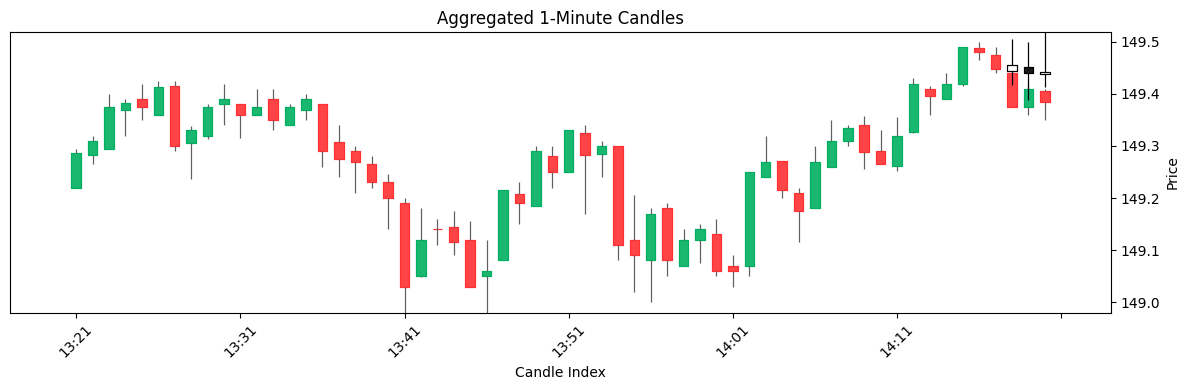

BAC 2023-06-01: 10:04 AM
tensor(0.2402) tensor(0.4901)
Base Loss Component: 0.5024787187576294
P/L Loss Component: 0.5744425654411316
Custom Loss: 0.8676179051399231


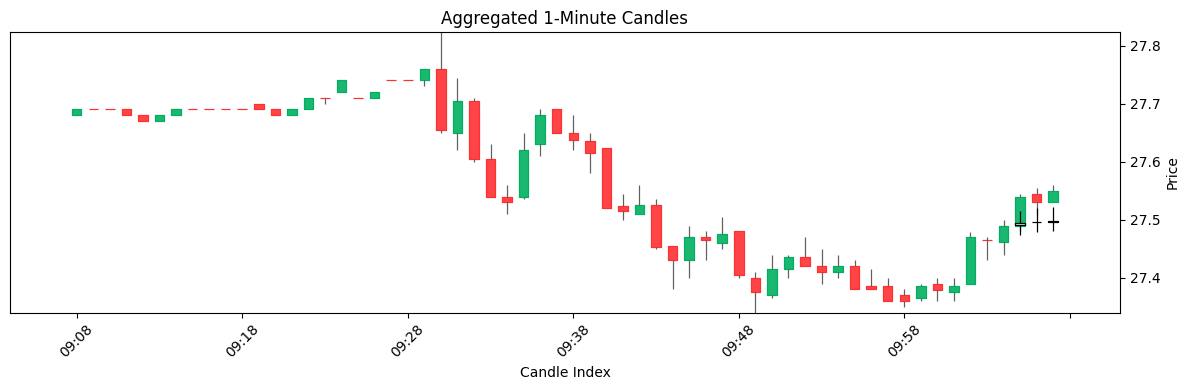

GOOGL 2023-01-04: 12:19 PM
tensor(0.0132) tensor(0.1150)
Base Loss Component: 0.3720118999481201
P/L Loss Component: 0.08776793628931046
Custom Loss: 0.4361134171485901


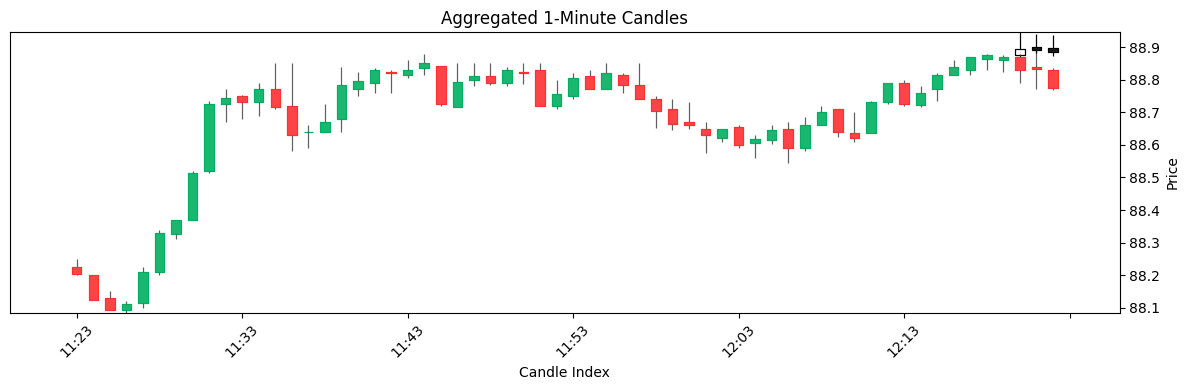

GOOGL 2023-04-13: 02:34 PM
tensor(0.0005) tensor(0.0227)
Base Loss Component: 0.38014543056488037
P/L Loss Component: 0.025356119498610497
Custom Loss: 0.3917645812034607


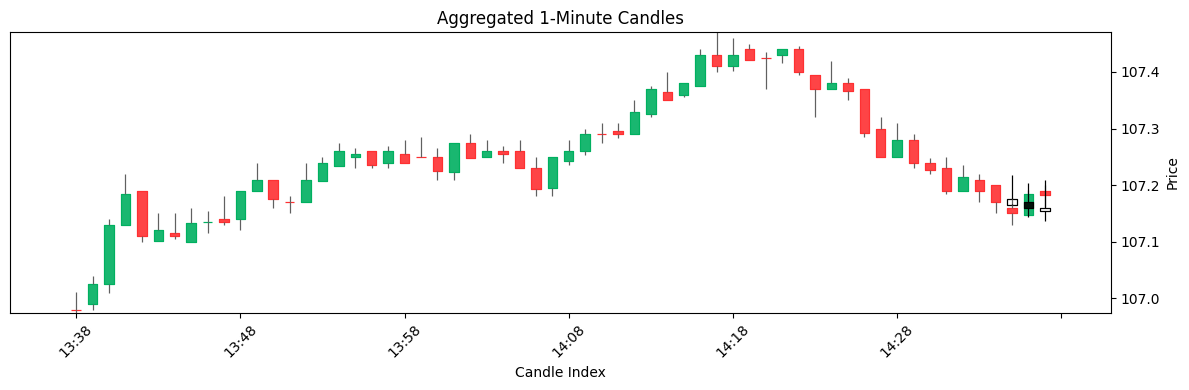

GOOGL 2023-07-12: 10:21 AM
tensor(0.0132) tensor(0.1150)
Base Loss Component: 0.38121259212493896
P/L Loss Component: 0.15786601603031158
Custom Loss: 0.4453098177909851


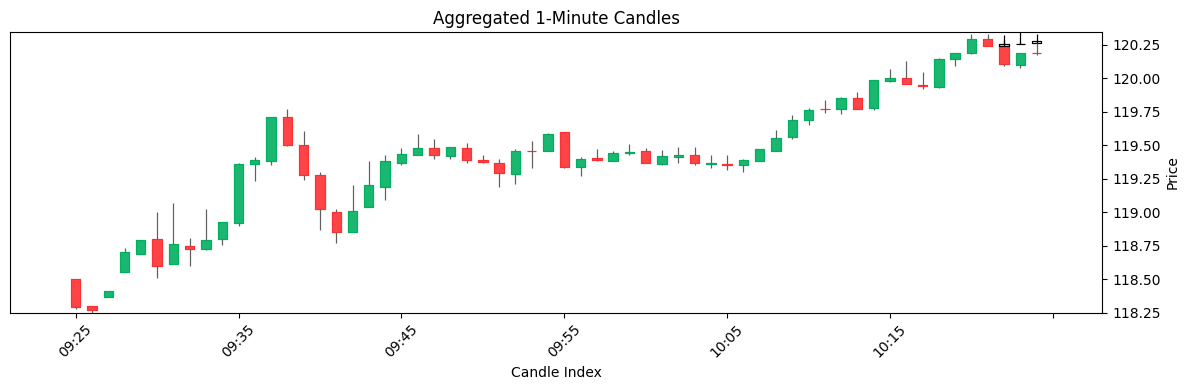

GOOGL 2023-10-27: 12:36 PM
tensor(2.3489e-06) tensor(0.0015)
Base Loss Component: 0.27300992608070374
P/L Loss Component: 0.01658511534333229
Custom Loss: 0.27377742528915405


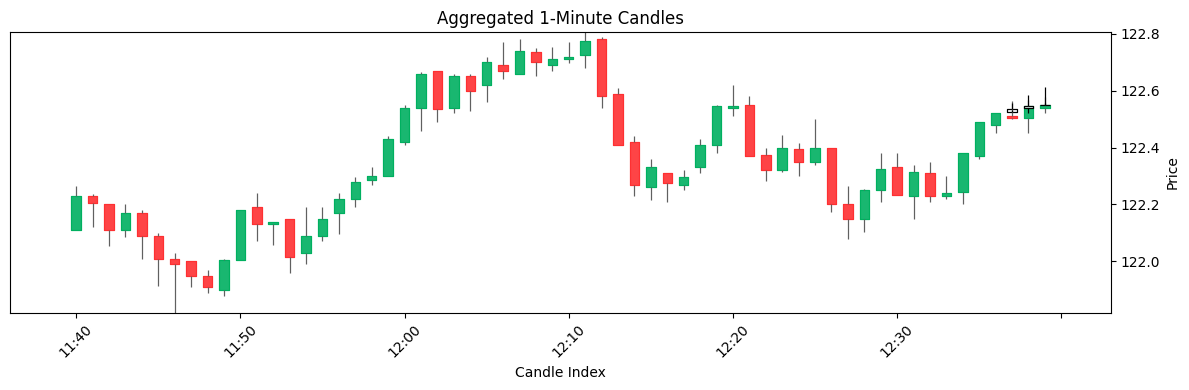

META 2023-06-01: 02:51 PM
tensor(0.0076) tensor(0.0874)
Base Loss Component: 0.32618972659111023
P/L Loss Component: 0.07289021462202072
Custom Loss: 0.37372058629989624


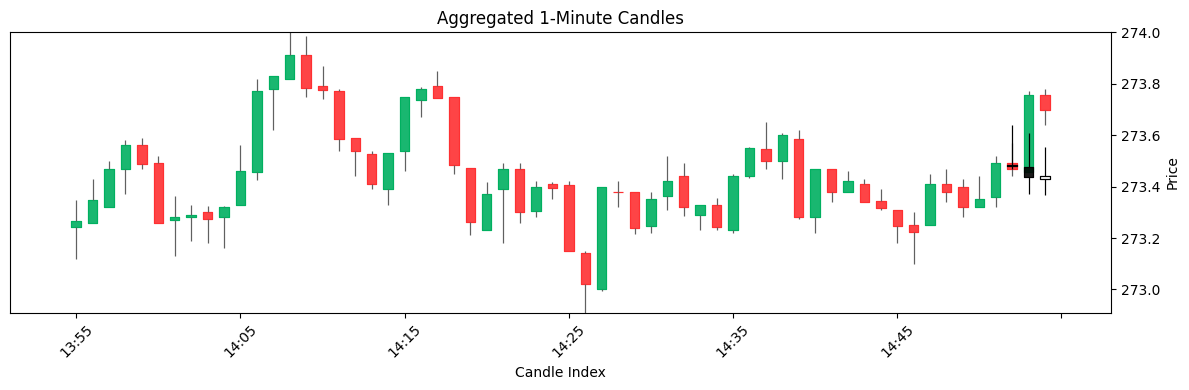

META 2023-08-10: 10:38 AM
tensor(0.0117) tensor(0.1083)
Base Loss Component: 0.42251959443092346
P/L Loss Component: 0.15016107261180878
Custom Loss: 0.48256194591522217


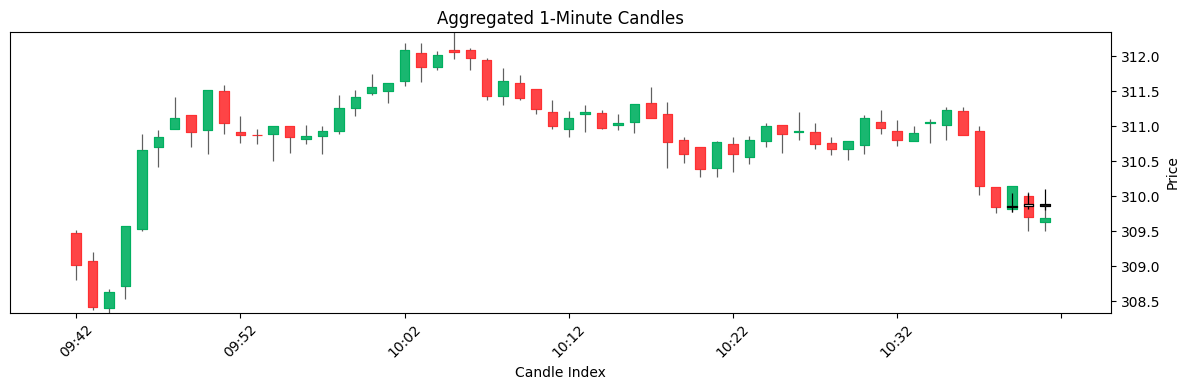

META 2023-12-05: 12:53 PM
tensor(0.0036) tensor(0.0601)
Base Loss Component: 0.35801470279693604
P/L Loss Component: 0.10687997937202454
Custom Loss: 0.3898842930793762


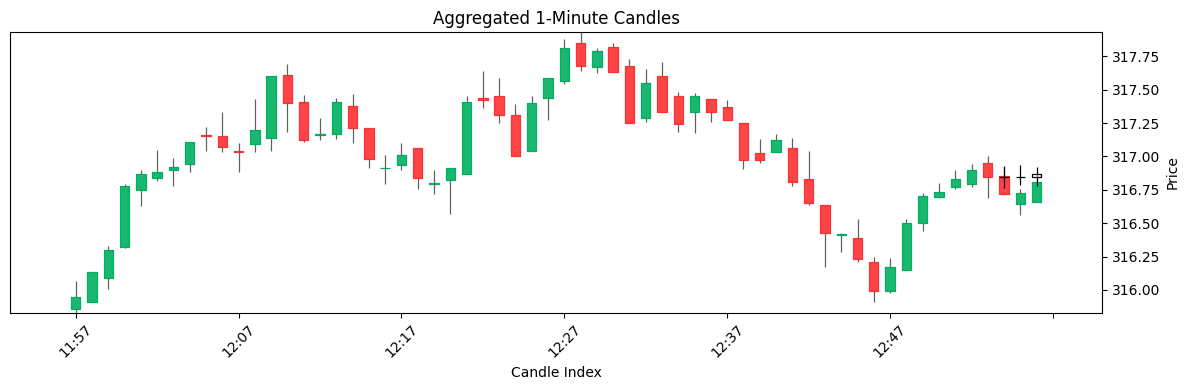

MSFT 2023-05-01: 03:08 PM
tensor(0.0168) tensor(0.1295)
Base Loss Component: 0.4104616045951843
P/L Loss Component: 0.12914611399173737
Custom Loss: 0.48361068964004517


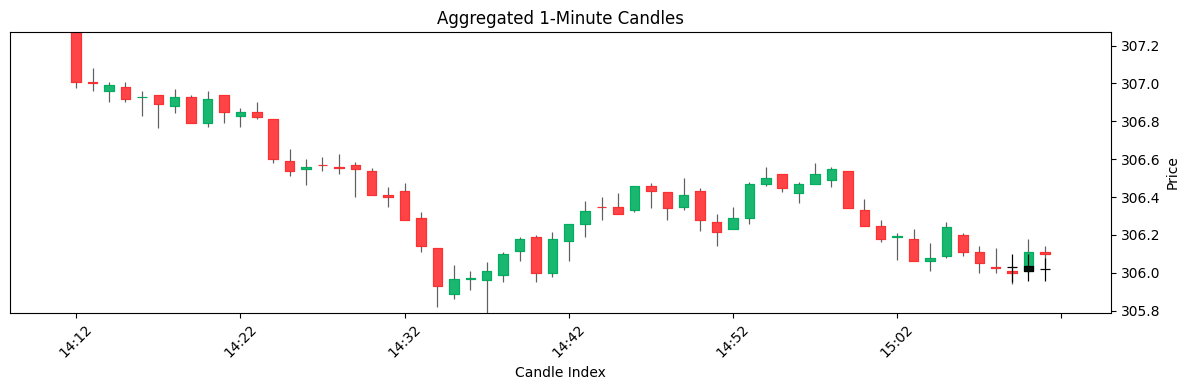

MSFT 2023-12-15: 10:55 AM
tensor(0.0133) tensor(0.1152)
Base Loss Component: 0.43102073669433594
P/L Loss Component: 0.1221696212887764
Custom Loss: 0.495231568813324


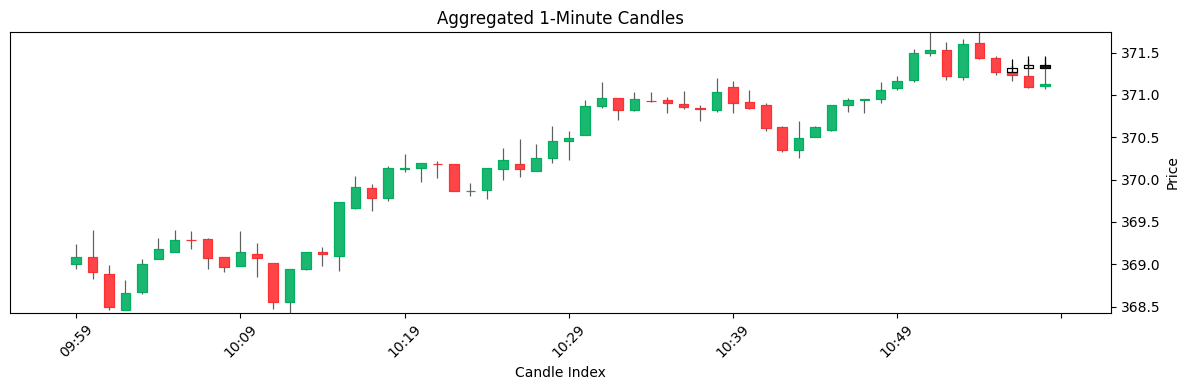

NVDA 2023-04-20: 01:10 PM
tensor(0.0334) tensor(0.1828)
Base Loss Component: 0.38620680570602417
P/L Loss Component: 0.154337540268898
Custom Loss: 0.4943304657936096


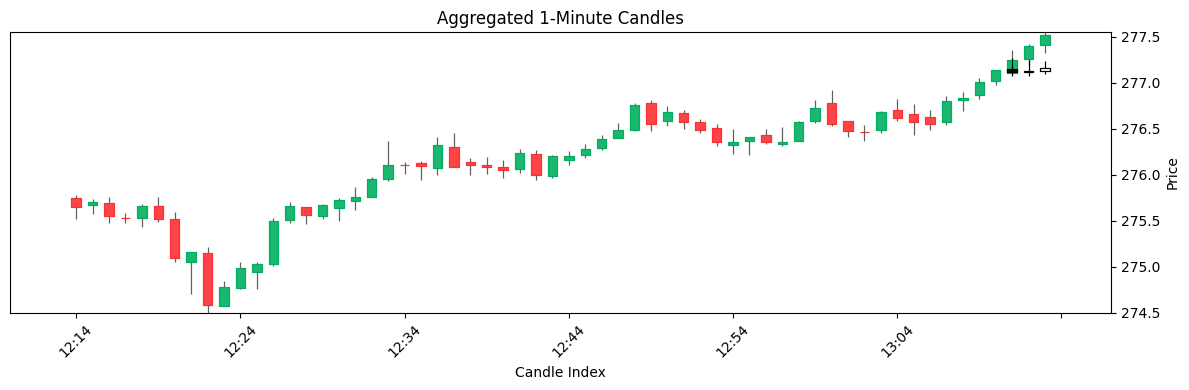

NVDA 2023-07-19: 03:25 PM
tensor(0.0268) tensor(0.1637)
Base Loss Component: 0.3579096794128418
P/L Loss Component: 0.1620911955833435
Custom Loss: 0.4531446099281311


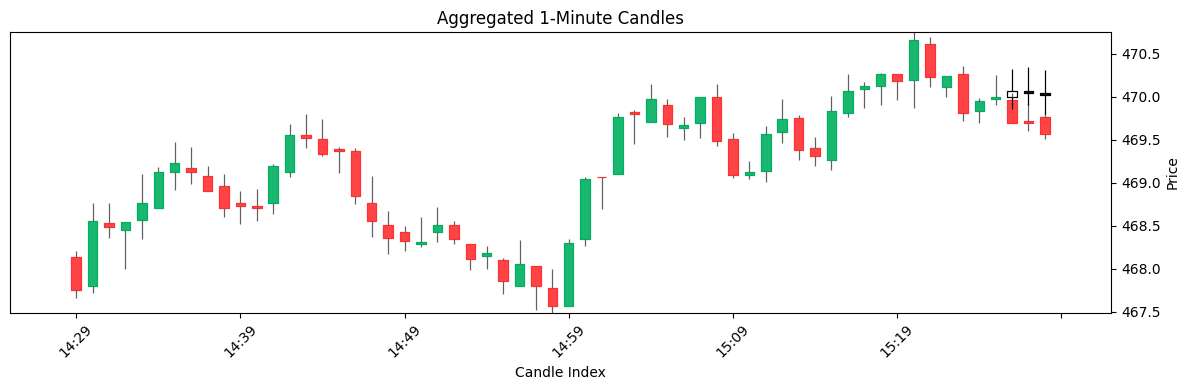

NVDA 2023-11-16: 11:12 AM
tensor(0.0041) tensor(0.0640)
Base Loss Component: 0.4332011938095093
P/L Loss Component: 0.27387821674346924
Custom Loss: 0.467259019613266


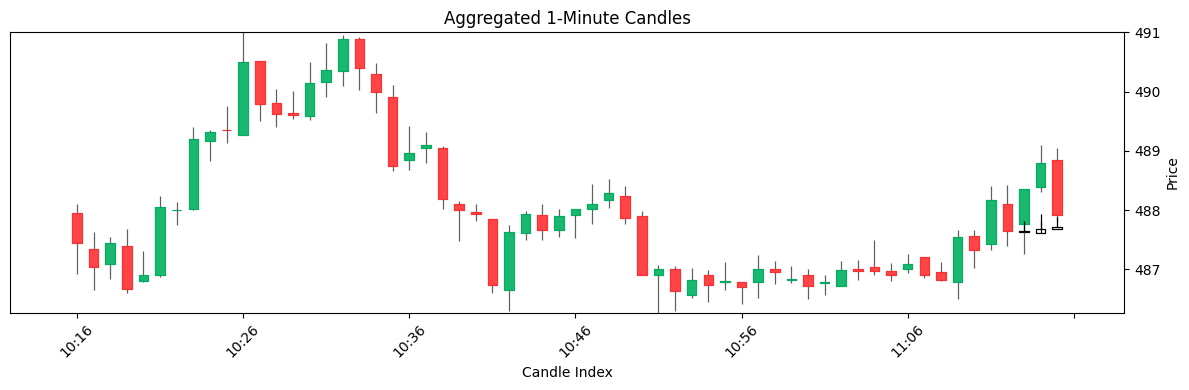

TSLA 2023-06-08: 01:27 PM
tensor(0.0001) tensor(0.0112)
Base Loss Component: 0.3558691740036011
P/L Loss Component: 0.015503128059208393
Custom Loss: 0.36151111125946045


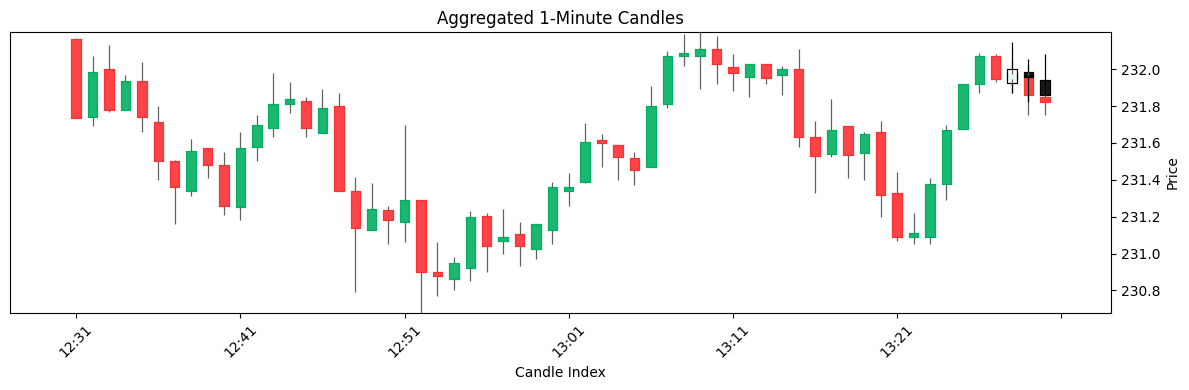

V 2023-03-13: 03:42 PM
tensor(0.1358) tensor(0.3685)
Base Loss Component: 0.4858632981777191
P/L Loss Component: 0.23839132487773895
Custom Loss: 0.7380220890045166


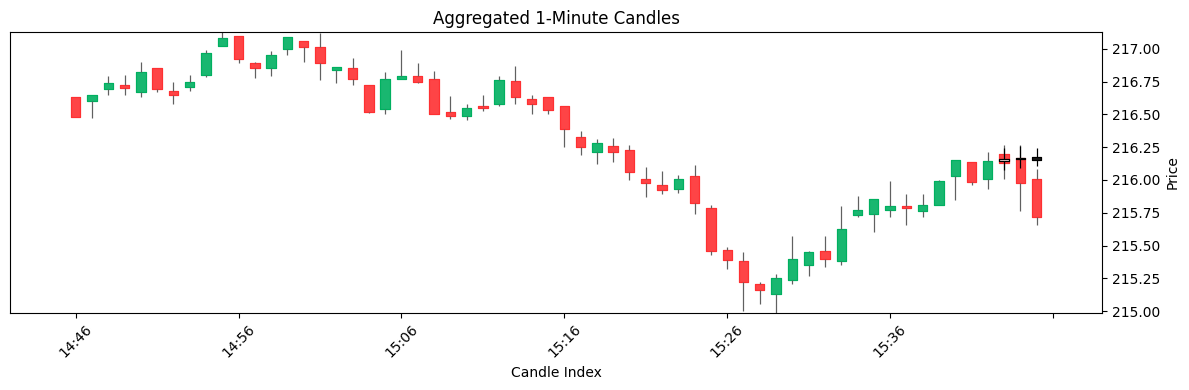

In [62]:
# Get 10 examples for testing the plotting the model's performance
for i in range(1, len(scaled_test_dataset), (len(scaled_test_dataset) - 1) // 20):
    _test_example = scaled_test_dataset[i]
    _unscaled_example = unscaled_test_dataset[i]
    infer_and_plot(_test_example)
    